# [Project Title]

- David Bellenberg: [email]
- Alexander James Mealor: [email]
- Alexander Ries: [email]
- Aleksander August Fowler Torp: [email]

In [2]:
! pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached fasttext-0.9.2-cp310-cp310-linux_x86_64.whl
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached torch-2.0.1-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached pytorch_lightning-2.0.2-py3-none-any.whl (719 kB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Usin

In [1]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import fasttext
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import NaiveBayesClassifier
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import gc
# Download Stopwords
nltk.download('stopwords') 
# Download Tokenization Requirements
nltk.download('punkt') 
# Download Lemmatization Requirements
nltk.download('wordnet') 



[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing and language filtering

In [4]:
df = pd.read_csv('/work/NLP/ds2.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913411 entries, 0 to 5913410
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   tag       object
 2   artist    object
 3   year      int64 
 4   views     int64 
 5   features  object
 6   lyrics    object
 7   id        int64 
dtypes: int64(3), object(5)
memory usage: 360.9+ MB


In [6]:
df.head()

,title,tag,artist,year,views,features,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


In [7]:
# Drop columns that are not needed
df.drop(columns=['views', 'features'], inplace=True)

In [8]:
# Value counts for each genre
df['tag'].value_counts()

tag
pop        2519256
rap        1962010
rock        892220
rb          225342
misc        208714
country     105869
Name: count, dtype: int64

In [9]:
# drop genre "misc" (miscellaneous) from df
df = df[df.tag != 'misc']

In [10]:
# check if only unique genres are in df
df['tag'].unique()

array(['rap', 'rb', 'rock', 'pop', 'country'], dtype=object)

In [11]:
# show nan values in each column
df.isnull().sum()

title      407
tag          0
artist       0
year         0
lyrics    1011
id           0
dtype: int64

In [12]:
# drop nan values in columns lyrics, tag, and title
df.dropna(subset=['lyrics', 'title'], inplace=True)

In [13]:
# show nan values in each column
df.isnull().sum()

title     0
tag       0
artist    0
year      0
lyrics    0
id        0
dtype: int64

In [15]:
# Load FastText's language identification model
model = fasttext.load_model('/work/NLP/fasttext/lid.176.bin')

# Detect language function
def detect_language(text):
    text = text.replace('\n', ' ')  # Replace newline characters with spaces
    predictions = model.predict(text, k=1)  # k is the number of language predictions to return
    lang = predictions[0][0].replace('__label__','')  # Get the language code
    return lang

In [16]:
# Detect language for each row in lyrics column
tqdm.pandas(desc="Detecting language")
df['language'] = df['lyrics'].progress_apply(detect_language)

Detecting language: 100%|██████████| 5703331/5703331 [11:36<00:00, 8192.42it/s] 


In [17]:
df['language'].value_counts()

language
en     4042601
es      280481
fr      199379
pt      171829
ru      168636
        ...   
mhr          1
hif          1
dsb          1
lez          1
or           1
Name: count, Length: 165, dtype: int64

In [18]:
# keep only english songs
df = df[df['language'] == 'en']

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4042601 entries, 0 to 5913410
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   tag       object
 2   artist    object
 3   year      int64 
 4   lyrics    object
 5   id        int64 
 6   language  object
dtypes: int64(2), object(5)
memory usage: 246.7+ MB


In [20]:
# Save df to pickle
#df.to_pickle('../data/df_cleaned_engl.pkl')

In [22]:
gc.collect()

1087

In [24]:
# Read cleaned and filtered df from pickle
df = pd.read_pickle('/work/NLP/df_cleaned_engl.pkl')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4042601 entries, 0 to 5913410
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   tag       object
 2   artist    object
 3   year      int64 
 4   lyrics    object
 5   id        int64 
 6   language  object
dtypes: int64(2), object(5)
memory usage: 246.7+ MB


In [26]:
genre_counts = df['tag'].value_counts()
genre_counts

tag
pop        1818130
rap        1207176
rock        737168
rb          187550
country      92577
Name: count, dtype: int64

In [27]:
genre_counts.describe()

count    5.000000e+00
mean     8.085202e+05
std      7.213716e+05
min      9.257700e+04
25%      1.875500e+05
50%      7.371680e+05
75%      1.207176e+06
max      1.818130e+06
Name: count, dtype: float64

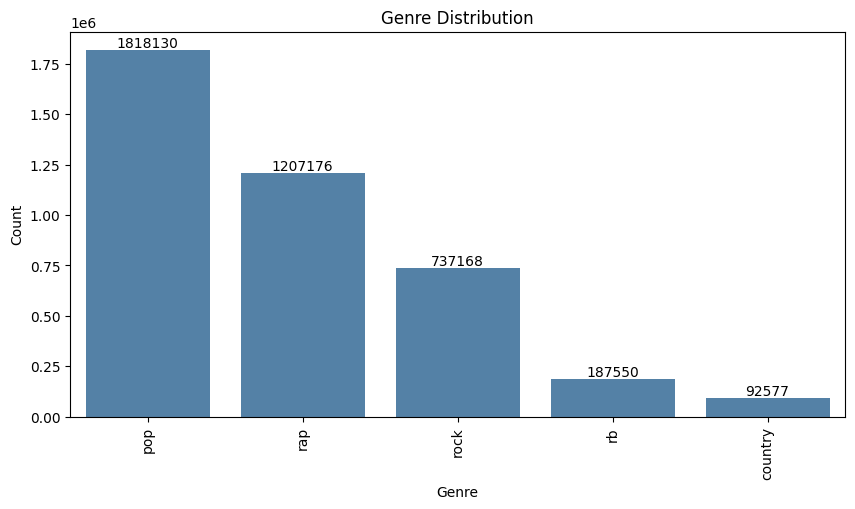

In [29]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='tag', order=df['tag'].value_counts().index, color='steelblue')
# Add count labels to the columns
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.xticks(rotation=90)
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [30]:
year_counts = df['year'].value_counts()
year_counts

year
2020    460151
2021    418109
2019    396736
2015    350990
2018    336073
         ...  
514          1
1748         1
1633         1
1783         1
1431         1
Name: count, Length: 485, dtype: int64

Most of the songs are from recent years whereas some songs are very old. Since the songs seem really old and the years are a bit odd, we will examine the years with low song counts closer.

In [31]:
odd_years = year_counts[year_counts == 2].index
filtered_df = df[df['year'].isin(odd_years)]
filtered_df

,title,tag,artist,year,lyrics,id,language
145757,The History of Tom Jones a Foundling Chap. 8.7,rap,Henry Fielding,1749,Containing better reasons than any which have ...,155315,en
145762,The History of Tom Jones a Foundling Chap. 8.9,rap,Henry Fielding,1749,Containing several dialogues between Jones and...,155320,en
208036,Advice to a Friend on Choosing a Mistress,rap,Benjamin Franklin,1745,"June 25, 1745\n\nMy dear Friend\n\nI know of n...",223606,en
216527,Put a Little Umph In It,rb,Jagged Edge,207,"[Intro: Jermaine Dupri, Ashtani, Kyle & Jagged...",235635,en
250149,FDB Fuck Dat Bitch G-Mix,rap,Young Dro,1415,"West Side, Bankhead, is where I'm from\nEveryt...",327414,en
...,...,...,...,...,...,...,...
5238604,Mityu pchelatuh,rock,HARMAN TAARSH,205,Kiro cuh e bati pederasa\nToi e ot romskata ra...,7022057,en
5553257,I shit fart pee pee,rap,A$AP Rocky,1686,I bee shitting... farting. IM BROWNING\n\n\nIM...,7418234,en
5566508,Play Me Like That Video Game,pop,Josef Bel Habib,994,Play Me Like That Video Game (Time to Level at...,7434368,en
5738079,GYM,rap,Tommy Stoner,499,[Instrumental],7654006,en


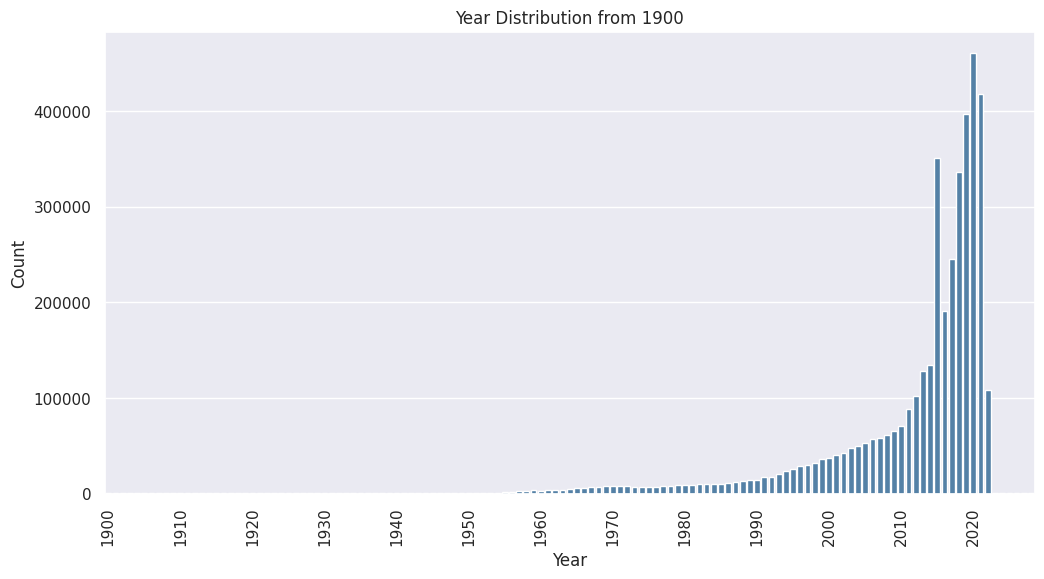

In [32]:
year_counts = df['year'].value_counts()
valid_years = year_counts.index

year_order = df['year'].sort_values().unique()
valid_years = valid_years[valid_years >= 1900]

valid_years = sorted(valid_years)  # Sort the valid years in ascending order


sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df[df['year'].isin(valid_years)], x='year', order=valid_years, color='steelblue')

# Display only every 10th year on the x-axis
every_10th_year = [year if i % 10 == 0 else '' for i, year in enumerate(valid_years)]
ax.set_xticklabels(every_10th_year)
plt.xticks(rotation=90)

plt.title('Year Distribution from 1900')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

<Figure size 1200x600 with 0 Axes>

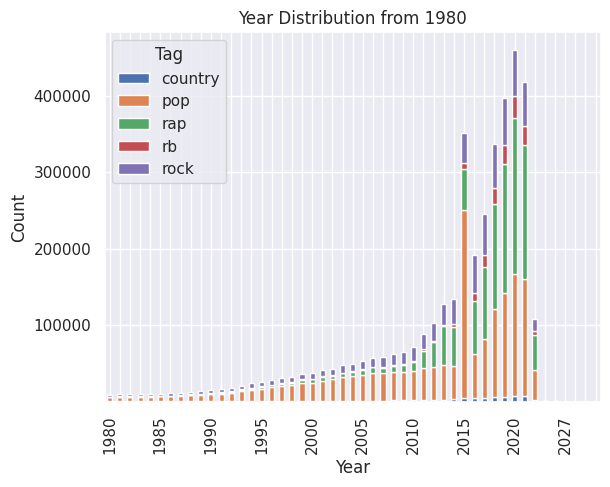

In [46]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Create a pivot table with counts for each tag and year combination
pivot_table = df[df['year'].isin(valid_years)].pivot_table(index='year', columns='tag', aggfunc='size', fill_value=0)

# Sort the valid years in ascending order
pivot_table = pivot_table.loc[valid_years]

# Plot the stacked bar chart
ax = pivot_table.plot(kind='bar', stacked=True)

# Display only every 10th year on the x-axis
every_10th_year = [year if i % 5 == 0 else '' for i, year in enumerate(valid_years)]
ax.set_xticklabels(every_10th_year)
plt.xticks(rotation=90)

plt.title('Year Distribution from 1980')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Tag')

plt.show()


Genius expaned in 2014, which could explain the huge growth in songs in the year 2015.

In [52]:
# Examining word_count
df['word_count'] = df['lyrics'].apply(lambda x: len(x.split()))

df['word_count'].value_counts().describe()

/tmp/ipykernel_1029/2350800110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['lyrics'].apply(lambda x: len(x.split()))


count     3044.000000
mean      1073.818988
std       2458.609085
min          1.000000
25%          1.000000
50%          5.000000
75%        334.750000
max      10464.000000
Name: count, dtype: float64

<Axes: xlabel='word_count', ylabel='Count'>

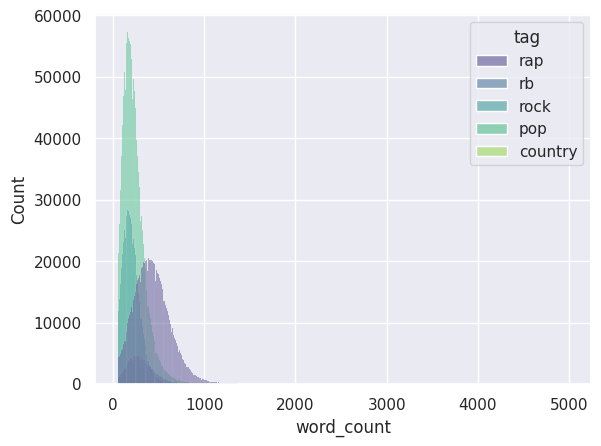

In [55]:
df = df[(df['word_count'] < 5000) & (df['word_count'] > 50)]

sns.histplot(data=df, x='word_count', bins=500, hue='tag', palette='viridis')

 The histplot above shows that rap songs contain usually more words than the other genres. 

In [71]:
gc.collect()

1602

## Lyrics Preprocessing

In [2]:
# Read cleaned and filtered df from pickle
df = pd.read_pickle('/work/NLP/df_cleaned_engl.pkl')

In [3]:
df.head()

,title,tag,artist,year,lyrics,id,language
0,Killa Cam,rap,Cam'ron,2004,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en
1,Can I Live,rap,JAY-Z,1996,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en
2,Forgive Me Father,rap,Fabolous,2003,Maybe cause I'm eatin\nAnd these bastards fien...,4,en
3,Down and Out,rap,Cam'ron,2004,[Produced by Kanye West and Brian Miller]\n\n[...,5,en
4,Fly In,rap,Lil Wayne,2005,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en


In [4]:
def preprocess(df, tokenize=True, lowercase=True, remove_stopwords=True, remove_punctuation=True, stem_or_lemm=None):
    # Drop language column
    df = df.drop(['language'], axis=1)

    # get word count in lyrics
    df['lyrics_word_count'] = df['lyrics'].apply(lambda x: len(str(x).split()))

    # Filtering songs with lyrics shorter than 25 words and longer than 5000
    df = df[(df['lyrics_word_count'] < 5000)]
    df = df[(df['lyrics_word_count'] > 25)]

    # Filtering songs published earlier than 1960 and before 2024
    df = df[(df['year'] >= 1960) & (df['year'] <= 2023)]

    # Remove new lines
    df['lyrics'] = df['lyrics'].str.replace('\n', ' ') 

    # Remove strings enclosed in brackets []
    df['lyrics'] = df['lyrics'].str.replace('\[.*?\]', '', regex=True) 
    
    # Remove substrings starting with a backslash \
    df['lyrics'] = df['lyrics'].str.replace('\\[^\s]*', '', regex=True) 
    
    # Remove leading and trailing whitespaces
    df['lyrics'] = df['lyrics'].str.strip()
    
    # Strip the string and ensure only one space between words
    df['lyrics'] = df['lyrics'].str.replace(r'\s+', ' ', regex=True).str.strip()

    if remove_punctuation == True:
        # Remove punctuation from the lyrics
        df['lyrics'] = df['lyrics'].str.replace('['+string.punctuation+']', '', regex=True)

    if lowercase == True:
        #lowercase everything
        df['lyrics'] = df['lyrics'].str.lower()
    
    #remove the words 'chorus' and 'verse'
    df['lyrics'] = df['lyrics'].str.replace('chorus', '')
    df['lyrics'] = df['lyrics'].str.replace('verse', '')

    if remove_stopwords == True:
        stop = stopwords.words('english')
        df['lyrics'] = df['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    if tokenize ==True:
        df['lyrics'] = df['lyrics'].apply(nltk.word_tokenize)

    if stem_or_lemm == 'stem':
        stemmer = SnowballStemmer("english")
        df['stemmed_lyrics'] = df['lyrics'].apply(lambda x: [stemmer.stem(word) for word in x])
    elif stem_or_lemm == 'lemm':
        lemmatizer = WordNetLemmatizer()
        df['lemmatized_lyrics'] = df['lyrics'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    else:
        print('No stemming or lemmatization needed.')

    return df

In [6]:
df_tokenized = preprocess(df.head(100), tokenize=True, lowercase=True, remove_stopwords=True, remove_punctuation=True, stem_or_lemm=None)
df_tokenized.to_pickle('/work/NLP/pkl_files_test/tokenized.pkl')

No stemming or lemmatization needed.


In [8]:
df_stemmed = preprocess(df.head(100), tokenize=True, lowercase=True, remove_stopwords=True, remove_punctuation=True, stem_or_lemm='stem')
df_stemmed.to_pickle('/work/NLP/pkl_files_test/stemmed.pkl')

In [10]:
df_lemmatized = preprocess(df.head(100), tokenize=True, lowercase=True, remove_stopwords=True, remove_punctuation=True, stem_or_lemm='lemm')
df_lemmatized.to_pickle('/work/NLP/pkl_files_test/lemmatized.pkl')

In [ ]:
df_word2vec = preprocess(df.head(100), tokenize=True, lowercase=True, remove_stopwords=False, remove_punctuation=True, stem_or_lemm=None)
df_word2vec.to_pickle('/work/NLP/pkl_files_test/word2vec_tokenized.pkl')

In [5]:
df_bert = preprocess(df, tokenize=False, lowercase=False, remove_stopwords=False, remove_punctuation=False, stem_or_lemm=None)
df_bert.to_pickle('/work/NLP/pkl_files_test/20230524_BERT.pkl')

No stemming or lemmatization needed.


## NB Classification

In [4]:
def nb_classification(train, label, vectorizer='bow'):

    train = train.apply(' '.join)

    # Split the data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(train, label, test_size=0.3, stratify=y, random_state=42)
    # Split test into test and validation set
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    if vectorizer == 'bow':
        vec = CountVectorizer()
    elif vectorizer == 'tfidf':
        vec = TfidfVectorizer()

    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)

    # Initialize the MultinomialNB
    nb = MultinomialNB()

    # Fit the model to the training data
    nb.fit(X_train_vec, y_train)

    # Predict the labels of the test set
    y_pred = nb.predict(X_test_vec)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    return report

## Random Forest Classification

In [ ]:
def rf_classification(train, label):

    # Initialize Random Over Sampler to handle imbalance
    oversampler = RandomOverSampler(random_state=42)

    # Split the data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(train, label, test_size=0.3, stratify=y, random_state=42)
    # Split test into test and validation set
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # Oversample only train set 
    X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)

    # Initialize the RF - class weight balanced to assist imbalance
    clf = RandomForestClassifier(n_jobs=-1, verbose=2, class_weight='balanced', random_state=42)

    # Fit the model to the oversampled training data
    clf.fit(X_train_res, y_train_res)

    # Predict the labels of the test set
    y_test_pred = clf.predict(X_test)

    # Generate classification report
    report = classification_report(y_test, y_pred)
    return report

### Tokenized

In [17]:
df = pd.read_pickle('/work/NLP/pkl_files/tokenized.pkl')

In [18]:
df.head()

,title,tag,artist,year,lyrics,id,lyrics_word_count
0,Killa Cam,rap,Cam'ron,2004,"[killa, cam, killa, cam, cam, killa, cam, kill...",1,762
1,Can I Live,rap,JAY-Z,1996,"[yeah, hah, yeah, rocafella, invite, somethin,...",3,548
2,Forgive Me Father,rap,Fabolous,2003,"[maybe, cause, im, eatin, bastards, fiend, gru...",4,574
3,Down and Out,rap,Cam'ron,2004,"[ugh, killa, baby, kanye, 1970s, heron, flow, ...",5,760
4,Fly In,rap,Lil Wayne,2005,"[ask, young, boy, gon, second, time, around, g...",6,432


In [20]:
#bow
bow_report = nb_classification(df['lyrics'], df['tag'], vectorizer='bow')
print(bow_report)

              precision    recall  f1-score   support

     country       0.33      0.18      0.23     25477
         pop       0.65      0.49      0.56    430965
         rap       0.83      0.79      0.81    298959
          rb       0.24      0.35      0.29     47343
        rock       0.40      0.62      0.48    191812

    accuracy                           0.59    994556
   macro avg       0.49      0.49      0.48    994556
weighted avg       0.63      0.59      0.60    994556



In [21]:
#tfidf
tfidf_report = nb_classification(df['lyrics'], df['tag'], vectorizer='tfidf')
print(tfidf_report)

              precision    recall  f1-score   support

     country       0.00      0.00      0.00     25477
         pop       0.58      0.91      0.71    430965
         rap       0.80      0.83      0.82    298959
          rb       0.13      0.00      0.00     47343
        rock       0.69      0.05      0.09    191812

    accuracy                           0.65    994556
   macro avg       0.44      0.36      0.32    994556
weighted avg       0.63      0.65      0.57    994556



In [26]:
# Collect garbage from RAM to prevent kernel from dying
gc.collect()

184

### Stemmed

In [3]:
df = pd.read_pickle('/work/NLP/pkl_files/stemmed.pkl')

In [4]:
df.head()

,title,tag,artist,year,lyrics,id,lyrics_word_count,stemmed_lyrics
0,Killa Cam,rap,Cam'ron,2004,"[killa, cam, killa, cam, cam, killa, cam, kill...",1,762,"[killa, cam, killa, cam, cam, killa, cam, kill..."
1,Can I Live,rap,JAY-Z,1996,"[yeah, hah, yeah, rocafella, invite, somethin,...",3,548,"[yeah, hah, yeah, rocafella, invit, somethin, ..."
2,Forgive Me Father,rap,Fabolous,2003,"[maybe, cause, im, eatin, bastards, fiend, gru...",4,574,"[mayb, caus, im, eatin, bastard, fiend, grub, ..."
3,Down and Out,rap,Cam'ron,2004,"[ugh, killa, baby, kanye, 1970s, heron, flow, ...",5,760,"[ugh, killa, babi, kany, 1970s, heron, flow, h..."
4,Fly In,rap,Lil Wayne,2005,"[ask, young, boy, gon, second, time, around, g...",6,432,"[ask, young, boy, gon, second, time, around, g..."


In [5]:
#bow
bow_report = nb_classification(df['stemmed_lyrics'], df['tag'], vectorizer='bow')
print(bow_report)

              precision    recall  f1-score   support

     country       0.32      0.18      0.23     25477
         pop       0.65      0.48      0.55    430965
         rap       0.83      0.79      0.81    298959
          rb       0.24      0.35      0.28     47343
        rock       0.39      0.63      0.48    191812

    accuracy                           0.59    994556
   macro avg       0.48      0.49      0.47    994556
weighted avg       0.63      0.59      0.59    994556



In [6]:
#tfidf
tfidf_report = nb_classification(df['stemmed_lyrics'], df['tag'], vectorizer='tfidf')
print(tfidf_report)

              precision    recall  f1-score   support

     country       0.00      0.00      0.00     25477
         pop       0.58      0.91      0.71    430965
         rap       0.80      0.83      0.81    298959
          rb       0.14      0.00      0.00     47343
        rock       0.70      0.05      0.09    191812

    accuracy                           0.65    994556
   macro avg       0.44      0.36      0.32    994556
weighted avg       0.63      0.65      0.57    994556



In [7]:
# Collect garbage from RAM to prevent kernel from dying
gc.collect()

0

### Lemmatized

In [2]:
df = pd.read_pickle('/work/NLP/pkl_files/lemmatized.pkl')

In [3]:
df.head()

,title,tag,artist,year,lyrics,id,lyrics_word_count,lemmatized_lyrics
0,Killa Cam,rap,Cam'ron,2004,"[killa, cam, killa, cam, cam, killa, cam, kill...",1,762,"[killa, cam, killa, cam, cam, killa, cam, kill..."
1,Can I Live,rap,JAY-Z,1996,"[yeah, hah, yeah, rocafella, invite, somethin,...",3,548,"[yeah, hah, yeah, rocafella, invite, somethin,..."
2,Forgive Me Father,rap,Fabolous,2003,"[maybe, cause, im, eatin, bastards, fiend, gru...",4,574,"[maybe, cause, im, eatin, bastard, fiend, grub..."
3,Down and Out,rap,Cam'ron,2004,"[ugh, killa, baby, kanye, 1970s, heron, flow, ...",5,760,"[ugh, killa, baby, kanye, 1970s, heron, flow, ..."
4,Fly In,rap,Lil Wayne,2005,"[ask, young, boy, gon, second, time, around, g...",6,432,"[ask, young, boy, gon, second, time, around, g..."


In [5]:
#bow
bow_report = nb_classification(df['lemmatized_lyrics'], df['tag'], vectorizer='bow')
print(bow_report)


              precision    recall  f1-score   support

     country       0.33      0.17      0.23     25477
         pop       0.65      0.49      0.56    430965
         rap       0.83      0.79      0.81    298959
          rb       0.24      0.34      0.28     47343
        rock       0.40      0.62      0.48    191812

    accuracy                           0.59    994556
   macro avg       0.49      0.48      0.47    994556
weighted avg       0.63      0.59      0.60    994556



In [6]:
#tfidf
tfidf_report = nb_classification(df['lemmatized_lyrics'], df['tag'], vectorizer='tfidf')
print(tfidf_report)

              precision    recall  f1-score   support

     country       0.00      0.00      0.00     25477
         pop       0.58      0.91      0.71    430965
         rap       0.80      0.83      0.82    298959
          rb       0.13      0.00      0.00     47343
        rock       0.70      0.05      0.09    191812

    accuracy                           0.65    994556
   macro avg       0.44      0.36      0.32    994556
weighted avg       0.63      0.65      0.57    994556



In [7]:
# Collect garbage from RAM to prevent kernel from dying
gc.collect()

0

## Word2Vec

### Building Average Vector Model

In [ ]:
df = pd.read_pickle('/work/NLP/pkl_files/word2vec_tokenized.pkl')
df.head()

In [ ]:
# Train Word2Vec model on entire corpus of lyrics
# Parameters set - individuals words must appear minimum of 5 times
# Window set to 5 words distance 
# CBOW algorithm
# Vector size = 100 

w2v = Word2Vec(df['tokenized_lyrics'].to_list(), min_count=5, workers=-1, window=5)

In [ ]:
# Iterate through songs/rows of df, check word exists in model vocab, if so find the vector
# calculate the mean for each row and return the average vector representation for song
df['word2vec_lyrics'] = df['tokenized_lyrics'].apply(lambda x: np.mean([w2v.wv[word] for word in x if word in w2v_model.wv.key_to_index], axis=0))


In [ ]:
# A few NaN vectors materialise - remove
df = df.dropna(subset=['word2vec_lyrics'])

In [ ]:
# Visualising Word2Vec embeddings using subsample of all songs

# Take a subsample with same number of songs per genre  
df_sample = df.groupby('tag').apply(lambda x: x.sample(n=1000, replace=True)).reset_index(drop=True)

# Extract the respective vectors
vectors = np.array(df_sample['word2vec_lyrics'].tolist())

# t-SNE reduces vectors from 100 dimensions to 2 
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=df_sample['tag'].astype('category').cat.codes, alpha=0.7)

handles, labels = scatter.legend_elements(prop="colors")
plt.legend(handles, df_sample['tag'].astype('category').cat.categories, title="Genres")

plt.show()


In [ ]:
# Visualising top 100 most frequently occured   

top_words = w2v.wv.index_to_key[:100]
word_vectors = np.array([w2v.wv[word] for word in top_words])

# t-SNE reduces vectors from 100 dimensions to 2 
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
for word, (x, y) in zip(top_words, word_vectors_2d):
    plt.annotate(word, (x, y))
plt.show()


### Random Forest - Average Vector

In [ ]:
rf_report = rf_classification(np.vstack(df['word2vec_lyrics'].values), df['tag'])
print(rf_report)

## Word2Vec - Embedding Layer Model